<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/TCC_PUCMinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data in Space Science

* Import librarys
* Download data
* Preprocessing Datasets
* Bulding models
* Test Models
* Compare results


## Check Version

Um problema da reprodutibilidade de experimentos computacionais esta na dinamicidade de versões de bibliotecas e funções que possuem módulos que são atualizados e decreipitados. Esse experimento foi desenvolvido entre 2022 e 2023. Para isso utilizamos as versões abaixos to python, keras, tensorflow:

In [ ]:
!python --version

Python 3.8.8


In [ ]:
#Importing Librarys 📚
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
#import math
import seaborn as sns
import pandas as pd
#import time # for time mesurment
import random
from matplotlib.pyplot import figure


from sklearn.model_selection import  GridSearchCV ,RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import pickle

#from xgboost import XGBClassifier
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.layers import Dropout, Activation, Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from IPython.display import HTML

import optuna
import pickle

seed = 55
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)

2.9.1


Para garantir a reprodutibilidade deste experimento é importante que as bibliotecas estejam todas na mesma versão o código a baixo deve produzir o seguinte output. Caso contrário instale as versões corretamente

```
numpy 1.20.1
keras 2.9.0
TensorFlow 2.9.0
sklearn 0.24.1
optuna 3.0.3
seaborn 0.11.1
pandas 1.4.3
matplotlib 3.5.2
```

In [ ]:
print('numpy',np.__version__)
print('keras',keras.__version__)
print('TensorFlow',tf.keras.__version__)
print('sklearn',sklearn.__version__)
print('optuna',optuna.__version__)
print('seaborn',sns.__version__)
print('pandas',pd.__version__)
print('matplotlib',matplotlib.__version__)


numpy 1.20.1
keras 2.9.0
TensorFlow 2.9.0
sklearn 0.24.1
optuna 3.0.3
seaborn 0.11.1
pandas 1.4.3
matplotlib 3.5.2


In [ ]:
import os
path = '/home/barauna/Documentos/PN_TCC' #os.getcwd()
os.chdir(path)

## Baixando os dados
https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07

In [ ]:
#Se tiver rodando esse código no google colab descomente as linhas abaixo
#Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')
#Importando e configurando o Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessando o diretório do Kaggle
%cd /content/drive/MyDrive/Kaggle/
# Fazendo o dowload do NASA data-set
!kaggle datasets download -d sameepvani/nasa-nearest-earth-objects
#Unziping data-set
!unzip "nasa-nearest-earth-objects.zip" -d "/content/"
# Fazendo o dowload do NASA data-set
!kaggle datasets download -d basu369victor/prediction-of-asteroid-diameter

# !unzip "kepler-exoplanet-search-results.zip" -d "/content/"

In [ ]:
# #Retorning to Sample folder! NOT NECESSERY
# %cd ..
# %cd ..
# %cd ..

## Setando parâmetros


In [ ]:
# Generate a list of 10 colors from the "Spectral" colormap in float format
colors = sns.color_palette("Spectral", n_colors=10, as_cmap=False)

# Convert the float values to RGB tuples
colors_rgb = [(int(r * 255), int(g * 255), int(b * 255)) for (r, g, b) in colors]
def rbg_to_hex(color): 
    return "#{:02x}{:02x}{:02x}".format(*color)
# Print the RGB tuples

div_colors = [rbg_to_hex(colors_rgb[0]),rbg_to_hex(colors_rgb[-1])]

#print('min',rbg_to_hex(colors_rgb[0]))
#print('max',rbg_to_hex(colors_rgb[-1]))

## Funções

In [ ]:
def plot_cmatrix(y_test, y_pred, title='Matriz de correlação'):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Verdadeiro', 'Falso'], yticklabels=['Verdadeiro', 'Falso'])#,vmin=0, vmax=5e4)

    # Set the axis labels and title
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title(f'{title}\nAcuracia - {round(metrics.accuracy_score(y_test,y_pred)*100,3)}%')
    
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_test, y_pred,color='C0',label='ROC curve'):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeira Positivo')
    plt.title('Curva característica de Operação do Receptor (ROC)')
    plt.legend(loc="lower right")    

# Análise de Dados

In [ ]:
#Lendo os dados
df_nasa = pd.read_csv('neo.csv')
df_nasa.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Primeiro observaremos a correlação entre todo os dados do nosso dataframe

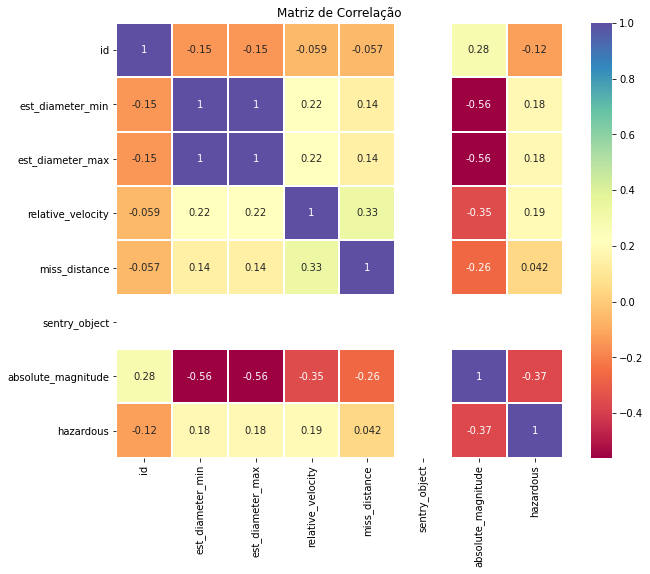

In [ ]:
#df = df_nasa
plt.figure(figsize=(10,8))
plt.title('Matriz de Correlação')
sns.heatmap(df_nasa.corr(),annot=True, linewidths = 0.1, linecolor = 'white', cmap="Spectral")
plt.show()

Naturalmente alguns dados não possuem interesse físico para a nossa analise dados. Dessa forma iremos definir um novo conjunto de dados que é um recorte dos dados gerais. Chamaremos esse recorte de `features`

In [ ]:
features = df_nasa.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1)
features.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


<AxesSubplot:title={'center':'Matriz de Correlação das Features'}>

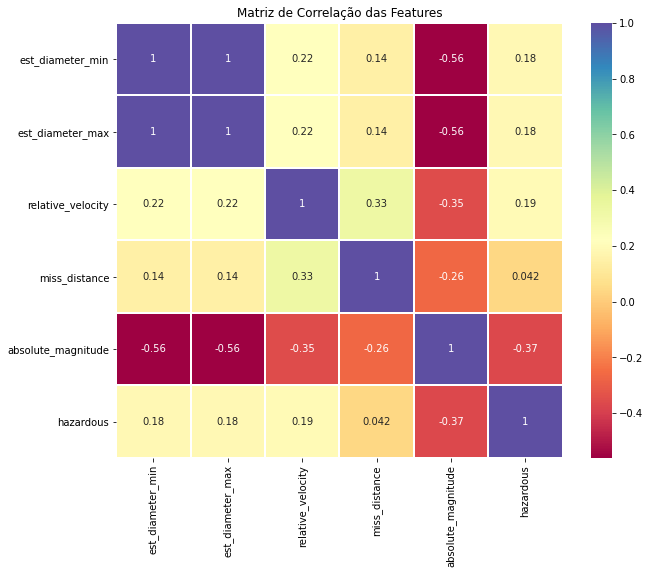

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Matriz de Correlação das Features')
sns.heatmap(features.astype(float).corr(),annot=True, linewidths = 0.1, linecolor = 'white', cmap="Spectral")

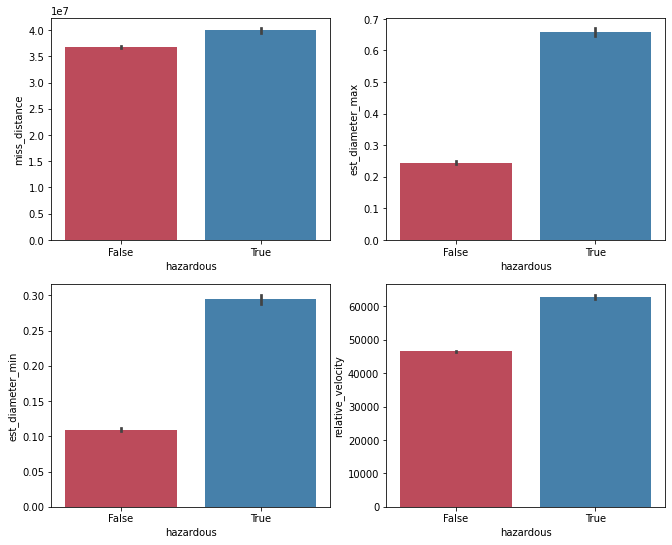

In [ ]:
colunas = ['miss_distance','est_diameter_max', 'est_diameter_min', 'relative_velocity']
plt.figure(figsize=(11,9))
b=1
for i in colunas:
    plt.subplot(2,2,b)
    sns.barplot(data=df_nasa,x='hazardous',y=i,palette=div_colors)
    b+=1


Não há uma ordem de grandeza específica de dados que determine se o uso de `kernel_regularizer` nas camadas intermediárias é necessário ou não. Em vez disso, é importante avaliar a complexidade da rede neural, a quantidade de dados disponíveis e a natureza do problema específico para decidir se a regularização é necessária e em que grau ela deve ser aplicada.

Em geral, quanto mais complexa for a rede neural, com muitas camadas e um grande número de parâmetros, maior será a probabilidade de ocorrer overfitting e, portanto, maior será a necessidade de regularização. Além disso, se a quantidade de dados disponíveis for relativamente pequena em comparação com a complexidade do modelo, a regularização pode ser necessária para evitar o overfitting.

O grau de regularização necessário depende do problema específico e do conjunto de dados em questão. Se o modelo estiver apresentando overfitting, pode ser necessário aumentar a intensidade da regularização. Por outro lado, se o modelo estiver apresentando underfitting, pode ser necessário reduzir a intensidade da regularização.

Em resumo, não existe uma regra universal para determinar se e em que grau deve ser aplicado o kernel_regularizer nas camadas intermediárias de uma rede neural. É importante avaliar cuidadosamente a complexidade da rede, a quantidade de dados disponíveis e o desempenho do modelo para decidir se a regularização é necessária e em que grau ela deve ser aplicada.

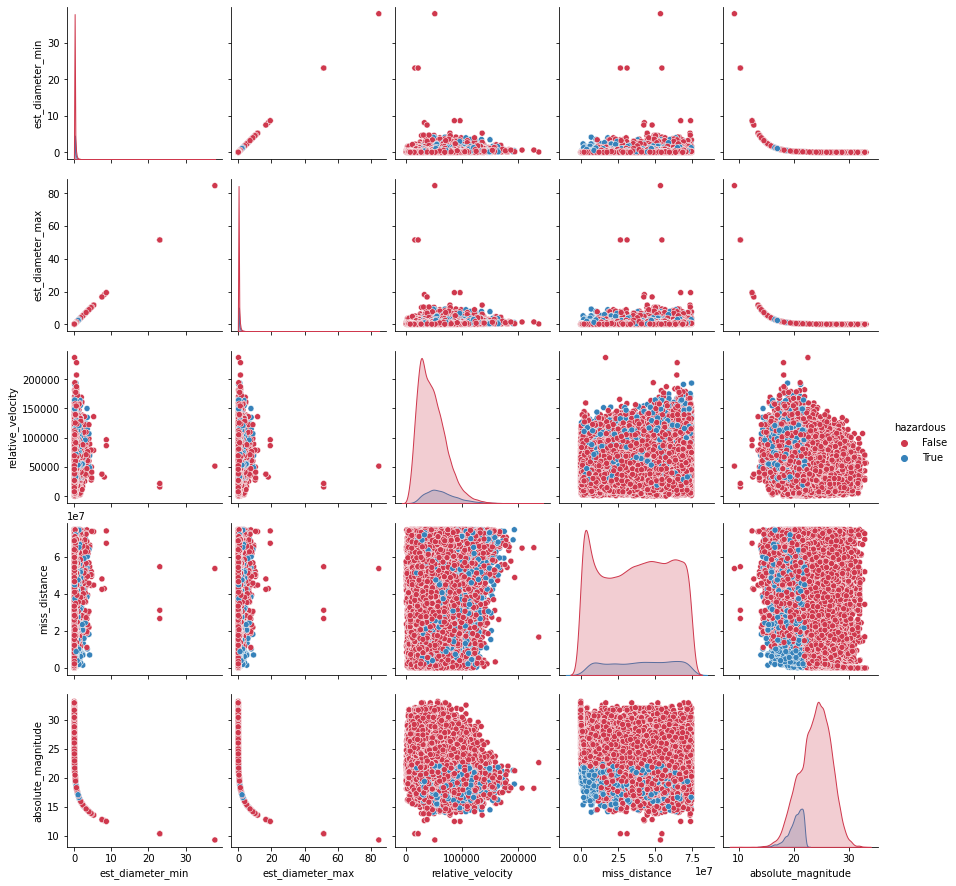

In [ ]:
sns.pairplot(features,hue='hazardous',palette=div_colors)#,corner=True)

<AxesSubplot:xlabel='absolute_magnitude', ylabel='Count'>

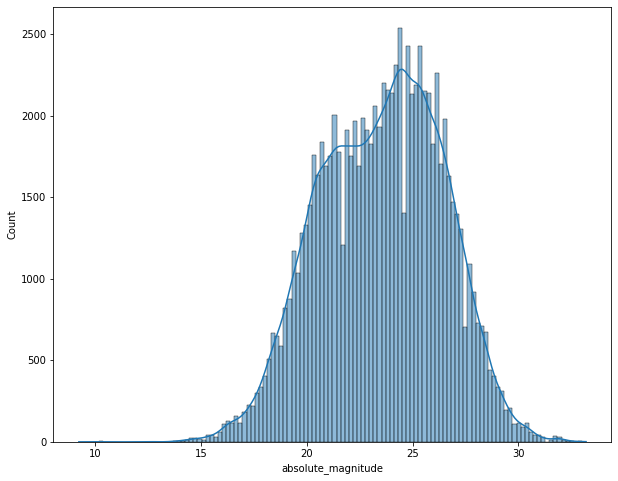

In [ ]:
plt.figure(figsize=(10,8))
sns.histplot(data=features,x='absolute_magnitude',kde=True)

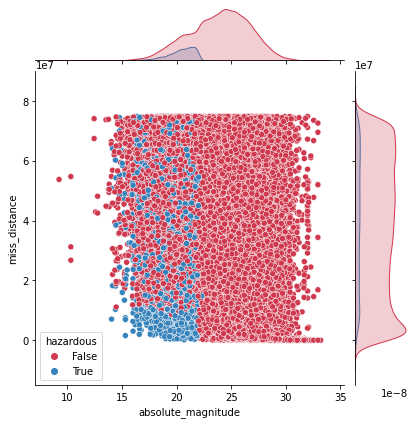

In [ ]:
sns.jointplot(data=features,x='absolute_magnitude',y='miss_distance',hue='hazardous',palette=div_colors)

In [ ]:
# #Defining the feature how will be our classify 🎯
# targets = features['hazardous']
# features = features.drop('hazardous', axis=1)
# targets.value_counts()

Nesse momento podemos observar pela análise de dados que que `est_diameter_max` possui uma alta correlação com dados fazendo dele uma feature não interessante para o nosso problema. Assim iremos retirá-lo do nosso experimento

<AxesSubplot:>

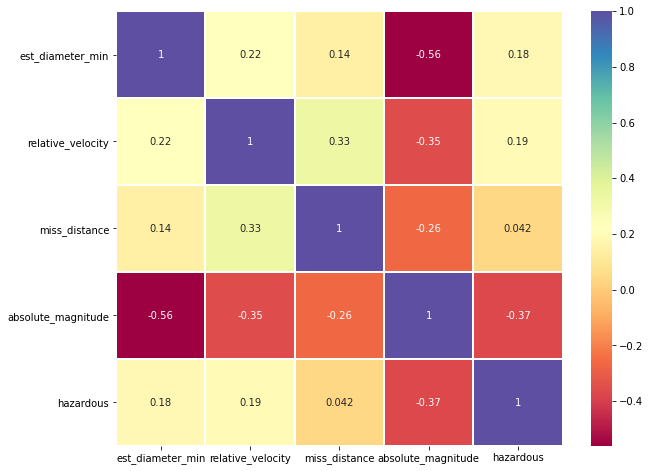

In [ ]:
#df = features.drop('est_diameter_max',axis=1,inplace=True)

features.drop('est_diameter_max',axis=1,inplace=True)


plt.figure(figsize=(10,8))
sns.heatmap(features.astype(float).corr(),annot=True, linewidths = 0.1, linecolor = 'white', cmap="Spectral")



In [ ]:
sns.pairplot(features,hue='hazardous',palette=div_colors)#,corner=True)

# Machine Learning

## Pré processando os dados

In [ ]:
df = features
scaler=StandardScaler() #instantiate
scaler.fit(df[['est_diameter_min', 'relative_velocity', 'miss_distance','absolute_magnitude']]) #fit
scaled = scaler.transform(df[['est_diameter_min', 'relative_velocity', 'miss_distance','absolute_magnitude']]) #transform

scaled_df = pd.DataFrame(scaled) #convert to dataframe

X = scaled_df
Y = df['hazardous']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=55)

## Floresta Aleatória

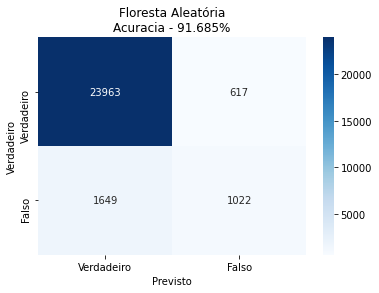

In [ ]:
rfc = RandomForestClassifier(n_estimators=100)#, max_depth=50, random_state=55)
rfc.fit(x_train,y_train)
pred_rfc = rfc.predict(x_test)
plot_cmatrix(y_test,pred_rfc,title='Floresta Aleatória')

In [ ]:
# #Floresta Aleatória com exploração de hiperparâmetros

# #rfc = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=55)
# rfc = RandomForestClassifier(n_jobs=-1, random_state=55)
# param_grid = {
#     'n_estimators': [50, 100,200],
#     'max_depth': [None, 5, 10]}#,
#     #'min_samples_split': [2, 5, 10],
#     #'min_samples_leaf': [1, 2, 4]
# #}
# rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5)
# #rfc.fit(x_train, y_train)
# #print("Best parameters: ", grid_search.best_params_)
# #print("Best score: ", grid_search.best_score_)
# rfc.fit(x_train,y_train)
# pred_rfc = rfc.predict(x_test)
# #pred_rfc = rfc.best_estimator_.predict_proba(x_test)[:,1]
# plot_cmatrix(y_test,pred_rfc,title='Floresta Aleatória')

## Regressão Logistica

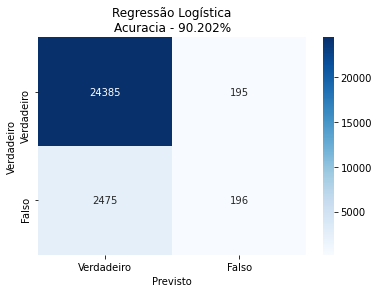

In [ ]:
logreg = LogisticRegression(n_jobs=-1, random_state=55)
logreg.fit(x_train,y_train)
pred_logreg = logreg.predict(x_test)
plot_cmatrix(y_test,pred_logreg,title='Regressão Logística')

In [ ]:
# #Explorando diferentes hiperparâmetros para o LogisticRegression
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga']
# }
# grid_search = GridSearchCV(logreg, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)
# # >>> Best parameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
# # >>> Best score:  0.9030746245183613

# pred_logreg = grid_search.predict(x_test)
# plot_cmatrix(y_test,pred_logreg,title='Regressão Logística')

## K-Means

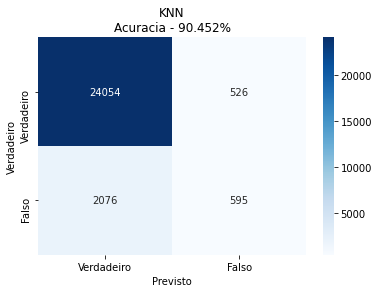

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11, n_jobs=-1)
knn.fit(x_train,y_train)
pred_knn = knn.predict(x_test)
#print("Knn Accuracy score =", metrics.accuracy_score(y_test,pred_knn))
plot_cmatrix(y_test,pred_knn,title='KNN')

In [ ]:
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9,11,13,15],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['ball_tree', 'kd_tree', 'brute']
# }
# grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)
# pred_knn = grid_search.predict(x_test)
# #print("Knn Accuracy score =", metrics.accuracy_score(y_test,pred_knn))
# plot_cmatrix(y_test,pred_knn,title='KNN')

## Naive Bayes

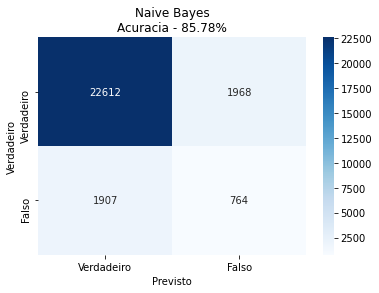

In [ ]:
nb = GaussianNB()
nb.fit(x_train,y_train)
pred_naiveb = nb.predict(x_test)
plot_cmatrix(y_test,pred_naiveb,title='Naive Bayes')


In [ ]:
nb = GaussianNB()
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}
grid_search = GridSearchCV(nb, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#pred_nb = nb.predict(x_test)
#plot_cmatrix(y_test,pred_nb,title='Naive Bayes')



Best parameters:  {'var_smoothing': 1e-09}
Best score:  0.8584257293386806


## Gradient Boosting



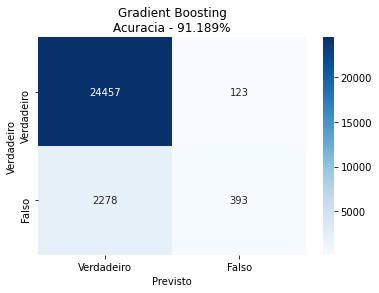

In [ ]:
gb=GradientBoostingClassifier(random_state=55)
gb.fit(x_train,y_train)
pred_gb=gb.predict(x_test)
plot_cmatrix(y_test,pred_gb,title='Gradient Boosting')

In [ ]:
# gb = GradientBoostingClassifier()
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(gb, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

KeyboardInterrupt: 

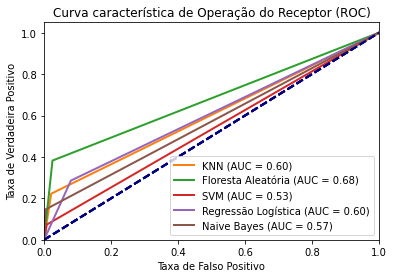

In [ ]:

plot_roc_curve(y_test, pred_knn, color='C1', label='KNN' )    
plot_roc_curve(y_test, pred_rfc, color='C2', label='Floresta Aleatória' )
plot_roc_curve(y_test, pred_logreg, color='C3', label='SVM' )
plot_roc_curve(y_test, pred_naiveb, color='C4', label='Regressão Logística' )
plot_roc_curve(y_test, pred_gb, color='C5', label='Naive Bayes' )


# Deep Learning

## MLP

In [ ]:
#Defining the feature how will be our classify 🎯
targets = features['hazardous']
features = features.drop('hazardous', axis=1)
targets.value_counts()

False    81996
True      8840
Name: hazardous, dtype: int64

In [ ]:
#Normalize data
scaler = MinMaxScaler() 
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
#features.head()

In [ ]:
## Split in Traing and Test
x_train, x_test, y_train, y_test = train_test_split(features, targets, random_state=55, test_size=0.3)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

### Rede Simples

Epoch 1/20
1988/1988 [==============================] - 11s 5ms/step - loss: 0.3246 - accuracy: 0.9000 - val_loss: 0.3048 - val_accuracy: 0.9020
Epoch 2/20
1988/1988 [==============================] - 9s 4ms/step - loss: 0.2973 - accuracy: 0.9030 - val_loss: 0.2941 - val_accuracy: 0.9020
Epoch 3/20
1988/1988 [==============================] - 8s 4ms/step - loss: 0.2872 - accuracy: 0.9030 - val_loss: 0.2845 - val_accuracy: 0.9020
Epoch 4/20
1988/1988 [==============================] - 7s 4ms/step - loss: 0.2782 - accuracy: 0.9030 - val_loss: 0.2758 - val_accuracy: 0.9020
Epoch 5/20
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2700 - accuracy: 0.9030 - val_loss: 0.2687 - val_accuracy: 0.9020
Epoch 6/20
1988/1988 [==============================] - 8s 4ms/step - loss: 0.2632 - accuracy: 0.9029 - val_loss: 0.2620 - val_accuracy: 0.9015
Epoch 7/20
1988/1988 [==============================] - 8s 4ms/step - loss: 0.2575 - accuracy: 0.9023 - val_loss: 0.2571 - val_accurac

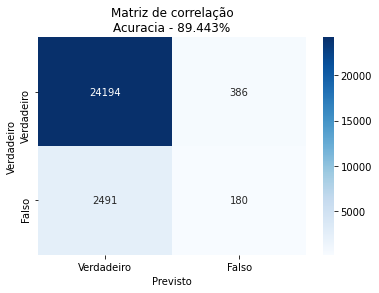

In [ ]:
# Model definition
#x_train, x_test, y_train, y_test
#i = 0
regul = 0
dropo = 0
moment= 0
model = []

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment)
model = (Sequential())
model.add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul),activation='relu'))
model.add(Dropout(dropo))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x_train.values, y_train.values, epochs=20, batch_size=32,
                        validation_data=(x_test.values,  y_test.values), verbose=1, shuffle=True)

pred_mlp = np.round(model.predict(x_test.values))
plot_cmatrix(y_test.values,pred_mlp)    

### Pesquisa por Grade

In [ ]:
# # Model definition
# #x_train, x_test, y_train, y_test
# #i = 0
# regul = [0.0,0.2,0.0,0.0,0.2,0.2]
# dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
# moment= [0.0,0.0,0.0,0.2,0.2,0.2]
# model_NASA_1 = []
# for i in range(len(regul)):
#   sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
#   model_NASA_1.append(Sequential())
#   model_NASA_1[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
#   model_NASA_1[i].add(Dropout(dropo[i]))
#   model_NASA_1[i].add(Dense(1, activation='sigmoid'))
#   model_NASA_1[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# #model.summary()

### Utilizando o Otuna

In [ ]:

def objective(trial):
    epochs       = 2
    neuron_min   = 10
    neuron_max   = 512
    min_layer    = 1
    max_layer    = 10
    # lr_mim       = 1e-4
    # lr_max       = 5e-1
    drop_max     = 0.3
    drop_min     = 0.0
    # momentum_max = 0.3
    # momentum_min = 0.0
    regul_max    = 0.3
    regul_min    = 0.0

    n_layers       = trial.suggest_int('n_layers', min_layer, max_layer)
    #lr             = trial.suggest_float('lr', lr_mim, lr_max)
    optimizer      = trial.suggest_categorical('optimiser',['SGD','Adam'])
    neurons   =[]
    activations   =[]
    dropouts   =[]
    regul = []
    for i in range(max_layer+1):
            neurons.append(trial.suggest_int(f'neurons{i+1}', neuron_min, neuron_max))
            activations.append(trial.suggest_categorical(f'activations{i+1}',["sigmoid", "relu", "tanh"]))
            dropouts.append(trial.suggest_float(f'dropouts{i+1}', drop_min, drop_max))
            regul.append(trial.suggest_float(f'regul{i+1}', regul_min, regul_max))
#Modelo
    model = Sequential()
    model.add(Dense(neurons[0], input_dim=x_train.shape[1], kernel_regularizer=l2(regul[0]),activation=activations[0]))
    model.add(Dropout(dropouts[0]))
    #Camadas ocultas
    for i in range(n_layers):
        model.add(Dense(neurons[i+1], kernel_regularizer=l2(regul[i+1]),activation=activations[i+1]))
        model.add(Dropout(dropouts[i+1]))
    #Camada de saída
    model.add(Dense(1, activation=activations[n_layers+1]))
    #Compilando o modelo
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    #model.summary()
    history = model.fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
                        validation_data=(x_test.values,  y_test.values), verbose=1, shuffle=True)
    loss, accuracy = model.evaluate(x_test, y_test)
    model.save(f'save_models/model{trial.number}.h5')
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

best_trial = study.best_trial
with open('best_trial.pkl', 'wb') as f:
    pickle.dump(best_trial, f)


[I 2023-04-04 15:32:10,273] A new study created in memory with name: no-name-c0d0e821-4bee-4bf5-af8f-5b2d1f32c51b


Epoch 1/2
1988/1988 [==============================] - 21s 10ms/step - loss: 48.7716 - accuracy: 0.1751 - val_loss: 13.8532 - val_accuracy: 0.0980
Epoch 2/2
852/852 [==============================] - 5s 5ms/step - loss: 13.7547 - accuracy: 0.0980


[I 2023-04-04 15:32:56,236] Trial 0 finished with value: 0.09801474958658218 and parameters: {'n_layers': 6, 'optimiser': 'SGD', 'neurons1': 57, 'activations1': 'relu', 'dropouts1': 0.1944377994682081, 'regul1': 0.06917327131385538, 'neurons2': 435, 'activations2': 'relu', 'dropouts2': 0.1759530271907596, 'regul2': 0.18264066327145276, 'neurons3': 225, 'activations3': 'tanh', 'dropouts3': 0.19417302821276342, 'regul3': 0.1306015881019506, 'neurons4': 341, 'activations4': 'sigmoid', 'dropouts4': 0.26972236119565746, 'regul4': 0.28413507110279135, 'neurons5': 512, 'activations5': 'relu', 'dropouts5': 0.10989426952138469, 'regul5': 0.0830459028053663, 'neurons6': 279, 'activations6': 'relu', 'dropouts6': 0.17031498071634033, 'regul6': 0.19690788758313968, 'neurons7': 49, 'activations7': 'relu', 'dropouts7': 0.1154131368201514, 'regul7': 0.15434624718547268, 'neurons8': 12, 'activations8': 'tanh', 'dropouts8': 0.26382156932266015, 'regul8': 0.2588047105145163, 'neurons9': 226, 'activations

Epoch 1/2
1988/1988 [==============================] - 25s 12ms/step - loss: 14.6733 - accuracy: 0.9013 - val_loss: 2.6696 - val_accuracy: 0.9020
Epoch 2/2
852/852 [==============================] - 5s 5ms/step - loss: 14.3891 - accuracy: 0.0980


[I 2023-04-04 15:33:52,227] Trial 1 finished with value: 0.09801474958658218 and parameters: {'n_layers': 7, 'optimiser': 'SGD', 'neurons1': 374, 'activations1': 'sigmoid', 'dropouts1': 0.23979999146633887, 'regul1': 0.011174966518384387, 'neurons2': 21, 'activations2': 'relu', 'dropouts2': 0.2461409233833073, 'regul2': 0.1812025020435038, 'neurons3': 477, 'activations3': 'tanh', 'dropouts3': 0.04093698084256383, 'regul3': 0.23604131853176868, 'neurons4': 222, 'activations4': 'sigmoid', 'dropouts4': 0.19142770280129673, 'regul4': 0.16050724395919289, 'neurons5': 61, 'activations5': 'sigmoid', 'dropouts5': 0.05362065355641341, 'regul5': 0.06368886471247052, 'neurons6': 346, 'activations6': 'sigmoid', 'dropouts6': 0.06950185565654672, 'regul6': 0.12006508924367765, 'neurons7': 351, 'activations7': 'relu', 'dropouts7': 0.2741673785735861, 'regul7': 0.08679383238815572, 'neurons8': 212, 'activations8': 'sigmoid', 'dropouts8': 0.24415949666394152, 'regul8': 0.00659429950312993, 'neurons9': 

In [ ]:
# Lendo o valor com o melhor resultado
with open('best_trial.pkl', 'rb') as f:
    best_trial = pickle.load(f)

print('Best trial:')
print(f'  Value: {best_trial.value}')
print('  Params:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value: 0.09801474958658218
  Params:
    n_layers: 6
    optimiser: SGD
    neurons1: 57
    activations1: relu
    dropouts1: 0.1944377994682081
    regul1: 0.06917327131385538
    neurons2: 435
    activations2: relu
    dropouts2: 0.1759530271907596
    regul2: 0.18264066327145276
    neurons3: 225
    activations3: tanh
    dropouts3: 0.19417302821276342
    regul3: 0.1306015881019506
    neurons4: 341
    activations4: sigmoid
    dropouts4: 0.26972236119565746
    regul4: 0.28413507110279135
    neurons5: 512
    activations5: relu
    dropouts5: 0.10989426952138469
    regul5: 0.0830459028053663
    neurons6: 279
    activations6: relu
    dropouts6: 0.17031498071634033
    regul6: 0.19690788758313968
    neurons7: 49
    activations7: relu
    dropouts7: 0.1154131368201514
    regul7: 0.15434624718547268
    neurons8: 12
    activations8: tanh
    dropouts8: 0.26382156932266015
    regul8: 0.2588047105145163
    neurons9: 226
    activations9: relu
    dropouts9: 

In [ ]:
# # Model definition
# #x_train, x_test, y_train, y_test
# #i = 0
# regul = [0.0,0.2,0.0,0.0,0.2,0.2]
# dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
# moment= [0.0,0.0,0.0,0.2,0.2,0.2]
# model_NASA_1 = []
# for i in range(len(regul)):
#   sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
#   model_NASA_1.append(Sequential())
#   model_NASA_1[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
#   model_NASA_1[i].add(Dropout(dropo[i]))
#   model_NASA_1[i].add(Dense(1, activation='sigmoid'))
#   model_NASA_1[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# #model.summary()

In [ ]:
N_rows, N_colluns = 1,2

figure(figsize=(10,5),dpi=80)
plt.suptitle("Topology NASA 1",y=0.99,fontsize=20)

plt.subplot(N_rows,N_colluns,1)
plt.plot(    history.history['accuracy'], color="C0")
plt.plot(    history.history['val_accuracy'], color="C1")
plt.title('Acuracia\nL2 '+str(regul)+' - Drop  '+str(dropouts)+' - Momen '+str(momentums)+'')
plt.ylabel('Accuracy')
plt.xlabel('Epoca')
plt.legend(['Treino', 'Validação'], loc='lower right')
# plt.grid()

plt.subplot(N_rows,N_colluns,2)
plt.plot(    history.history['loss'], color="C0")
plt.plot(    history.history['val_loss'], color="C1")
plt.title('Perda\nL2 '+str(regul)+' - Drop  '+str(dropouts)+' - Momen '+str(momentums)+'')
plt.ylabel('Perda')
plt.xlabel('Epoca')
plt.legend(['Treino', 'Validação'], loc='upper left')
# plt.grid()

plt.show()

In [ ]:

#pred_mlp = model.predict(x_test.values)
pred_mlp = np.round(model.predict(x_test.values))
plot_cmatrix(y_test.values,pred_mlp)

In [ ]:


i = 1
#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle('Topology NASA 1')
for i in range(0,1):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul)+' - Drop  '+str(dropouts)+' - Momen '+str(momentums)+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model.predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul)+' - Drop  '+str(dropouts)+' - Momen '+str(momentums))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model.predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# References

https://www.kaggle.com/code/keshavkapil/data-analysis-random-forest

https://www.kaggle.com/code/omarabdelaleem/logistic-regression-knn

https://www.kaggle.com/code/taskinemre/classification-training

https://www.kaggle.com/code/avijo9/gradient-boosting-model-91-acc